# XLNet 预训练模型及命名实体识别

#### 介绍

在之前的实验中我们介绍和使用了 BERT 预训练模型和 GPT-2 预训练模型，分别进行了文本分类和文本生成实验。在本次实验中，我们将介绍 XLNet 预训练模型，并使用其进行命名实体识别实验。

- XLNet 在 BERT 和 GPT-2 上的改进
- XLNet 模型结构
- 使用 XLNet 进行命名实体识别实验

谷歌的团队继 BERT 模型之后，在 2019 年中旬又 [提出了 XLNet 模型](https://arxiv.org/abs/1906.08237)。XLNet 在多达 20 个任务上均取得了超越 BERT 的成绩，还在如问答系统、自然语言推理、情感分析、文本排序等任务上超过了目前的最好成绩。

下面是 XLNet 在 [GLUE](https://gluebenchmark.com/) 上的测试结果：

Model | MNLI | QNLI | QQP | RTE | SST-2 | MRPC | CoLA | STS-B
--- | --- | --- | --- | --- | --- | --- | --- | ---
BERT-Large | 86.6 | 92.3 | 91.3 | 70.4 | 93.2 | 88.0 | 60.6 | 90.0
XLNet-Base | 86.8 | 91.7 | 91.4 | 74.0 | 94.7 | 88.2 | 60.2 | 89.5
XLNet-Large | **89.8** | **93.9** | **91.8** | **83.8** | **95.6** | **89.2** | **63.6** | **91.8**

### XLNet 在 BERT 和 GPT-2 上的改进

#### BERT 的缺点

可以说 XLNet 是 BERT 的增强版，但它与 BERT 又有许多不同之处。下面，我们将详细介绍一下。

在第一次实验中提到的，BERT 是自编码模型（Autoencoding），换一种说法来说就是，BERT 以遮蔽语言模型（Masked Language Model）为训练目标。训练自回归模型时，输入语句的一些词会被随机替换成 `[MASK]` 标签，然后训练模型预测被标签掩盖的词。

我们可以从这个过程中看到两个缺点：

1. 错误地假设了被覆盖词与被覆盖词之间是独立的。
2. 使预训练和微调时的输入不统一。

缺点 1 是指，在进行预测时，由于部分词被 `[MASK]` 覆盖，所以当 BERT 模型在预测一个被覆盖词时，忽略了其他的覆盖词对他的影响。也就是假设了所有被覆盖词是不相关的，很明显可以知道这个假设是错误的。

缺点 2 是指，在预训练是我们使用了 `[MASK]` 标签把部分词覆盖，而在微调预训练好的模型时，我们并不会使用到这个标签，这就导致了预训练过程和微调过程不符。

#### GPT-2 的缺点

在上一次实验中我们介绍了，GPT-2 是自回归模型（Autoregressive），即通过待预测词之前或之后的文本作为语境信息进行预测。

从数学上来说，在一个文本序列 $x = (x_1, ..., x_T)$ 中，自回归模型会计算待预测词的前方乘积 $p(x) = \prod^{T}_{t=1}p(x_t|x_{<t})$ ，其中 $x_{<t}$ 表示 $x_t$ 之前的词。同理，预测词的后方乘积可以表示为：$p(x) = \prod^{T}_{t=1}p(x_t|x_{>t})$.

但是自回归模型的一个很明显的缺点就是，它只能考虑一个单方向的语境。很多时候的下游任务，如自然语言理解，会同时需要前后两个方向的语境信息

介绍完 BERT 所代表的自编码模型和 GPT-2 所代表的自回归模型的固有缺点，下面就要介绍一下 XLNet 是如何针对这两类模型的缺点进行的改进。

#### XLNet 的改进

研究人员在设计 XLNet 模型时，考虑到要克服自编码模型和自回归模型的缺点，并且要结合它们的优势，设计出了排列语言模型（Permutation Lanuage Model）。如下图所示，排列语言模型的思想是，既然自回归语言模型只能获取单向语境，那就通过改变字词排列位置的方法将双向的语句排列到单向。

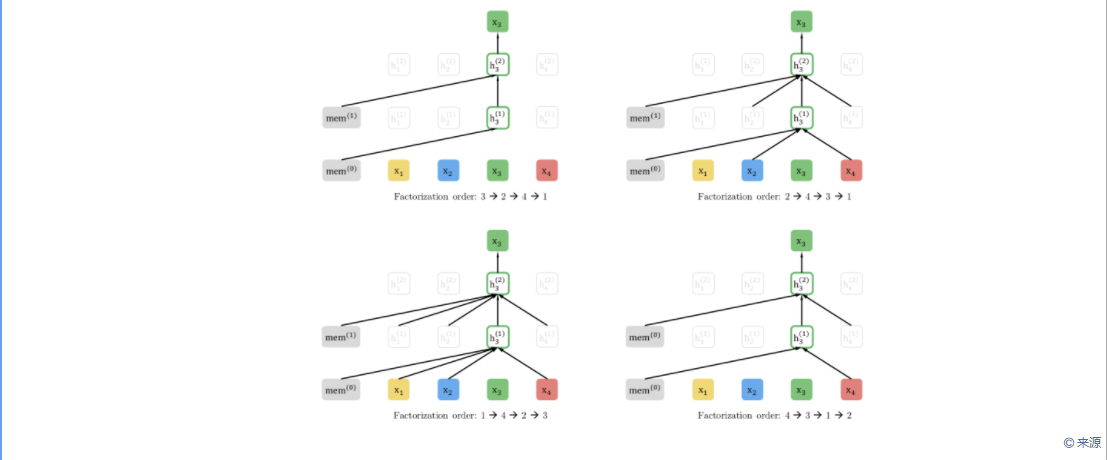

以图中右上角的部分为例，当
字词排列变为 "2 -> 4 -> 3 -> 1"，并且训练目标为预测第 3 个字词时，输入模型的为词 2 和词 4 的信息。这样模型即保留了自回归模型的特点，又使得模型学习到了双向的语境信息。

需要注意，改变排列不会实际改变字词的位置信息，即排在第三位的词的位置向量还是会对应该词是第三位的信息。

在具体实现时，通过对注意力机制的掩膜的作用之一就是进行改变来达到改变排列的目的，可以参照下图红框部分，

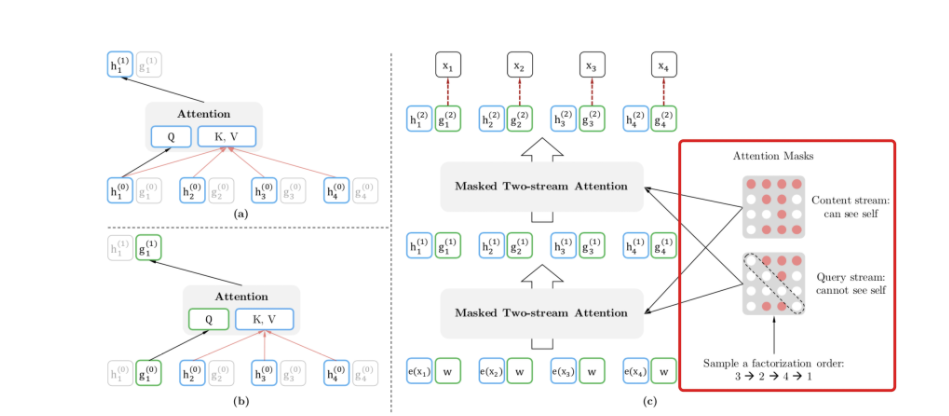

此图的其他部分含义在下文会介绍，这里先说一下红框的部分。以上半部分的第二行为例，表示当对单词 2 之后的词进行预测时，对每个单词添加的掩膜，并且此时的排列顺序为 "3 -> 2 -> 4 -> 1"。所以，这时添加到单词 2 和 3 的掩膜值应为 1 ，表示模型可以看到的词，而其余词的值应为 0。同时我们也可以看到图中第二行中第 2 和 3 列对应的掩膜都被标成了红色。上半部分的其他行同理。

而图中下半部分的不同是，下半部分添加的掩膜可以使得模型看不到每个待预测的词，这样当模型预测单词 2 时就不会产生模型已经见过单词 2 的问题。

### XLNet 模型结构

#### SentencePiece 分词方法

XLNet 模型使用了 [SentencePiece](https://github.com/google/sentencepiece) 的分词方法，SentencePiece 是谷歌开源的自然语言处理工具包。它的原理是统计出现次数多的片段，则认为该片段是一个词。

SentencePiece 工具特别之处在于，它不依赖于之前的训练，而是通过从给定的训练集中学习，并且它不会因为语言不同而有不一样的表现，因为它把所有字符串中的字符都认为是 Unicode 字符。

可以说使用 SentencePiece 优化了 BERT 使用的 WordPiece 方法对中文分词效果不好的问题。

#### 双流自注意力机制

从总体结构上来说，XLNet 的模型结构和 BERT 的结构差异不大，都是以 Transformer 为基础。但 XLNet 模型使用了特别的注意力机制，即双流自注意力机制（Two-Stream Self-Attention），XLNet 的双流自注意力机制使用了两种特征表征单元，分别为内容表征单元和询问表征单元。

内容表征单元是对上文信息的表示，会包含当前的词。询问表征单元包含对除当前词之外的上文信息的表示，以及包含当前词的位置信息，而不能访问当前词的内容信息。

内容表征单元与询问表征单元构成了两种信息流，这两种信息流不断向上传递，在最后输出询问单元的信息。并且我们可以从下图的红框部分看到，最后的输出的预测结果中对应的字词顺序和输入时相同。

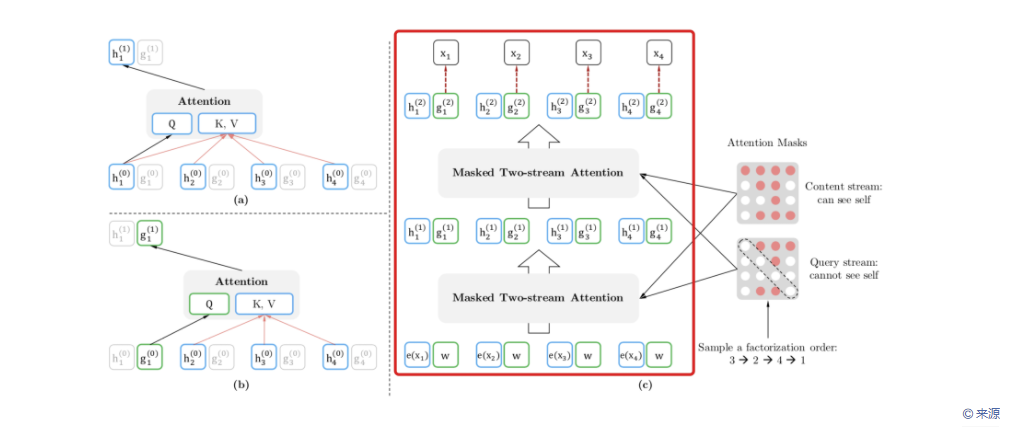

下面详细了解一下这个图中的各部分，首先图（a）部分表示的是内容流注意力（Content stream attention），图（b）部分表示的是询问流注意力（Query stream attention）。我们可以看到在图（b）中词 1 对应的只有询问表征单元被输入，而在图（a）中词 1 的内容表征单元也被输入了。图（c）部分表示的是模型如何应用双流自注意力机制。而图（c）右侧是注意力掩膜，我们在上文中也有介绍。添加掩膜的作用除了达到改变排列的目的，还达到了使模型在内容流注意力中能看到当前词，而在询问流注意力中不能看到当前词的目的。

除了上面提到的方法，XLNet 还使用了部分预测的方式，因为自回归语言模型是从第一个词预测到最后一个词，但在预测的初始阶段，由于已知的语句信息较少，模型很难收敛，所以实际只选择预测语句后 1/K 的词，而前面 1-1/K 的部分作为上下文信息。

### XLNet 命名实体识别

上面，我们介绍了 XLNet 在 BERT 和 GPT-2 基础上的改进之处，以及 XLNet 模型所使用的一些特别的方法。接下来我们将使用 XLNet 的预训练模型进行命名实体识别实验。命名实体识别（Named Entity Recognition，简称 NER），是指识别文本中具有特定意义的实体，主要包括人名、地名、机构名、专有名词等。命名实体识别是信息抽取的重要一步，被广泛应用在自然语言处理领域。

本次实验中我们使用的训练和测试数据来源为 [CoNLL-2003](https://www.clips.uantwerpen.be/conll2003/ner/)， CoNLL-2003 数据集是以新闻语料为基础，标注的实体有四种，分别为：公司、地点、人名和不属于以上三类的实体。分别命名为 `ORG`， `LOC`， `PER`， `MISC`，实体的第一个字标为 `B-ORG`， `B-LOC`， `B-PER`， `B-MISC`，第二个字标为 `I-ORG`， `I-LOC`， `I-PER`， `I-MISC`，标注为 `O` 的字词表示它不属于任何一个短语。

下面我们将使用在 PyTorch-Transformers 模型库中封装好的 `XLNetTokenizer()` 和 `XLNetModel` 类来实际进行一下 XLNet 预训练模型应用。首先，需要安装 PyTorch-Transformers。

In [ ]:
!pip install pytorch-transformers==1.0  # 安装 PyTorch-Transformers

因为原始数据结构较复杂，所以我们提前将数据重新整理过，已按照如下的标签标注数据。

In [ ]:
# 标签数据所对应的字符串含义
label_dict = {'O':0, 'B-ORG':1, 'I-ORG':2, 'B-PER':3, 'I-PER':4, 'B-LOC':5, 'I-LOC':6, 'B-MISC':7, 'I-MISC':8, 'X':9, '[PAD]':10}

可以注意到上面的标签中多了 `X` 和 `[PAD]` 标签，它们的含义分别为：因为分词会使得某些原本完整的单词断开，而断开的多出来的部分我们设为标签 `X`。`[PAD]` 标签对应则的是填补的字符。

接下来要下载数据集，我们已经提前下载好并存放在蓝桥云课服务器中，可通过以下命令读取。 数据集需要再想办法 

In [ ]:
## 蓝桥 自己的数据集  

In [3]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/1372/conell2003.zip"
!unzip -o "conell2003.zip"

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [ ]:
train_samples = []
train_labels = []

with open('./train.txt', 'r') as f:
    while True:
        s1 = f.readline()
        if not s1:
            # 如果读取到内容为空，则读取结束
            break
        s2 = f.readline()
        _ = f.readline()
        train_samples.append(s1.replace('\n', ''))
        train_labels.append(s2.replace('\n', ''))

len(train_samples), len(train_labels)

由于上文提到的，分词会使某些完整的词断开，所以分词后，我们要在原始数据的基础上再进行标签的增加。例如词 “She's”，会被分为 “She”，“'”，“s”，三个词，这时就将原本词 “She's” 对应的标签 O 标在词 “She” 上，而 “'”，“s” 分别表为 X 和 X。下面的代码就是上述标签修改的具体实现。

In [ ]:
from pytorch_transformers import XLNetTokenizer

# 使用 XLNet 的分词器
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

input_ids = []
input_labels = []
for text, ori_labels in zip(train_samples, train_labels):
    l = text.split(' ')
    labels = []
    text_ids = []
    for word, label in zip(l, ori_labels):
        if word == '':
            continue
        tokens = tokenizer.tokenize(word)
        for i, j in enumerate(tokens):
            if i == 0:
                labels.append(int(label))
                text_ids.append(tokenizer.convert_tokens_to_ids(j))
            else:
                labels.append(9)
                text_ids.append(tokenizer.convert_tokens_to_ids(j))
    input_ids.append(text_ids)
    input_labels.append(labels)

len(input_ids), len(input_labels)

在准备好数据后，这里使用 PyTorch 提供的 DataLoader() 构建训练集数据集表示，使用 TensorDataset() 构建训练集数据迭代器。

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

del train_samples
del train_labels

for j in range(len(input_ids)):
    # 将样本数据填充至长度为 128
    i = input_ids[j]
    if len(i) != 128:
        input_ids[j].extend([0]*(128 - len(i)))

for j in range(len(input_labels)):
    # 将样本数据填充至长度为 128
    i = input_labels[j]
    if len(i) != 128:
        input_labels[j].extend([10]*(128 - len(i)))

# 构建数据集和数据迭代器，设定 batch_size 大小为 8
train_set = TensorDataset(torch.LongTensor(input_ids),
                          torch.LongTensor(input_labels))
train_loader = DataLoader(dataset=train_set,
                          batch_size=8,
                          shuffle=True)
train_loader

检查是否机器有 GPU，如果有就在 GPU 运行，否则就在 CPU 运行。

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

由于 XLNet 预模型体积很大，且托管在外网，所以本次实验先从蓝桥云课镜像服务器下载预训练模型，本地实验无需此步骤。

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/1372/xlnet-base-shiyanlou.zip"
!unzip -o "xlnet-base-shiyanlou.zip"

下面构建用于命名实体识别类，命名实体识别本质上是在进行分类，在 XLNet 模型下加入一个 Dropout 层用于防止过拟合，和一个 Linear 全连接层。

In [ ]:
import torch.nn as nn
from pytorch_transformers import XLNetModel

class NERModel(nn.Module):
    def __init__(self, num_class=11):
        super(NERModel, self).__init__()
        # 读取 XLNet 预训练模型
        self.model = XLNetModel.from_pretrained("./")
        self.dropout = nn.Dropout(0.1)
        self.l1 = nn.Linear(768, num_class)

    def forward(self, x, attention_mask=None):
        outputs = self.model(x, attention_mask=attention_mask)
        x = outputs[0]  # 形状为 batch * seqlen * 768
        x = self.dropout(x)
        x = self.l1(x)
        return x

定义损失函数。这里使用了[交叉熵（Cross Entropy）](https://baike.baidu.com/item/交叉熵/8983241?fr=aladdin)作为损失函数。

In [ ]:
def loss_function(logits, target, masks, num_class=11):
    criterion = nn.CrossEntropyLoss(reduction='none')
    logits = logits.view(-1, num_class)
    target = target.view(-1)
    masks = masks.view(-1)
    cross_entropy = criterion(logits, target)
    loss = cross_entropy * masks
    loss = loss.sum() / (masks.sum() + 1e-12)  # 加上 1e-12 防止被除数为 0
    loss = loss.to(device)
    return loss

实体化类，定义损失函数，建立优化器。

In [ ]:
from torch.optim import Adam

model = NERModel()
model.to(device)
model.train()

optimizer = Adam(model.parameters(), lr=1e-5)

开始训练。

In [ ]:
from torch.autograd import Variable
import time

pre = time.time()

epoch = 3

for i in range(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)

        optimizer.zero_grad()

        # 生成掩膜
        mask = []
        for sample in data:
            mask.append([1 if i != 0 else 0 for i in sample])
        mask = torch.FloatTensor(mask).to(device)

        output = model(data, attention_mask=mask)
        
        # 得到模型预测结果
        pred = torch.argmax(output, dim=2)

        loss = loss_function(output, target, mask)
        loss.backward()

        optimizer.step()

        if ((batch_idx+1) % 10) == 1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'.format(
                i+1, batch_idx, len(train_loader), 100. *
                batch_idx/len(train_loader), loss.item()
            ))

        if batch_idx == len(train_loader)-1:
            # 在每个 Epoch 的最后输出一下结果
            print('labels:', target)
            print('pred:', pred)

print('训练时间：', time.time()-pre)

训练结束后，可以使用验证集观察模型的训练效果。

读取验证集数据和构建数据迭代器的方式与训练集相同。

In [ ]:
eval_samples = []
eval_labels = []

with open('./dev.txt', 'r') as f:
    while True:
        s1 = f.readline()
        if not s1:
            break
        s2 = f.readline()
        _ = f.readline()
        eval_samples.append(s1.replace('\n', ''))
        eval_labels.append(s2.replace('\n', ''))

len(eval_samples)

In [ ]:
# 这里使用和训练集同样的方式修改标签，不再赘述
input_ids = []
input_labels = []
for text, ori_labels in zip(eval_samples, eval_labels):
    l = text.split(' ')
    labels = []
    text_ids = []
    for word, label in zip(l, ori_labels):
        if word == '':
            continue
        tokens = tokenizer.tokenize(word)
        for i, j in enumerate(tokens):
            if i == 0:
                labels.append(int(label))
                text_ids.append(tokenizer.convert_tokens_to_ids(j))
            else:
                labels.append(9)
                text_ids.append(tokenizer.convert_tokens_to_ids(j))
    input_ids.append(text_ids)
    input_labels.append(labels)

del eval_samples
del eval_labels

for j in range(len(input_ids)):
    # 将样本数据填充至长度为 128
    i = input_ids[j]
    if len(i) != 128:
        input_ids[j].extend([0]*(128 - len(i)))

for j in range(len(input_labels)):
    # 将样本数据填充至长度为 128
    i = input_labels[j]
    if len(i) != 128:
        input_labels[j].extend([10]*(128 - len(i)))

# 构建数据集和数据迭代器，设定 batch_size 大小为 1
eval_set = TensorDataset(torch.LongTensor(input_ids),
                         torch.LongTensor(input_labels))
eval_loader = DataLoader(dataset=eval_set,
                         batch_size=1,
                         shuffle=False)
eval_loader

将模型设置为验证模式，输入验证集数据。

In [ ]:
from tqdm.notebook import tqdm

model.eval()

correct = 0
total = 0

for batch_idx, (data, target) in enumerate(tqdm(eval_loader)):
    data = data.to(device)
    target = target.float().to(device)

    # 生成掩膜
    mask = []
    for sample in data:
        mask.append([1 if i != 0 else 0 for i in sample])
    mask = torch.Tensor(mask).to(device)

    output = model(data, attention_mask=mask)
    
    # 得到模型预测结果
    pred = torch.argmax(output, dim=2)

    # 将掩膜添加到预测结果上，便于计算准确率
    pred = pred.float()
    pred = pred * mask
    target = target * mask

    pred = pred[:, 0:mask.sum().int().item()]
    target = target[:, 0:mask.sum().int().item()]

    correct += (pred == target).sum().item()
    total += mask.sum().item()

print('正确分类的标签数：{}，标签总数：{}，准确率：{:.2f}%'.format(
    correct, total, 100.*correct/total))

可以看到最后的准确率在 90% 以上。在应用提取实体时，有时还会用添加规则的方式提取完整实体词，或将最后预测标签时的 Softmax 层替换为 条件随机场 提高准确率，由于上述内容不是本实验重点，感兴趣的同学可以自行查找资料学习。

### 实验总结

在本次实验中我们了解了 BERT 和 GPT-2 的升级版 XLNet，它综合了两个模型的优点，即不会引入遮蔽标签产生的噪声、不会产生预训练和微调不符的问题，并且能够同时融合上下文的语境信息。然后我们进行了 XLNet 的命名实体识别实验，得到了不错的表现。

<i class="fa fa-link" aria-hidden="true"> 相关链接</i> 

- [XLNet: Generalized Autoregressive Pretraining for Language Understanding](https://arxiv.org/abs/1906.08237)
- [XLNet 模型实现](https://github.com/zihangdai/xlnet)